### Drifter location update Janet Duffy-Anderson

In [2]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import datetime

import urllib

import cmocean

def cmocean_to_leaflet(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    
    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, "#{:02x}{:02x}{:02x}".format(C[0], C[1], C[2])])
        
    return pl_colorscale

thermal = cmocean_to_leaflet(cmocean.cm.thermal, 1000)
thermal[-1] = [1.0, '#FFFFFF'] ### replace highest color value with white (so all data at extreme + end is white)

def rgb2hex(r,g,b):
    hex = "#{:02x}{:02x}{:02x}".format(r,g,b)
    return hex

def color_normalize(cmin,cmax,value):
    return (value-cmin)/(cmax-cmin)

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

tol = .00001


/Volumes/WDC_internal/Users/bell/anaconda2/lib/python2.7/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [3]:
class ARGOS_SERVICE(object):
    r"""Download and parse data from the ARGOS Archive"""

    @staticmethod
    def get_data(filename=None, ARGOS_Type=None):
        r"""
        Basic Method to open files.  Specific actions can be passes as kwargs for instruments
        """

        fobj = open(filename)
        data = fobj.read()


        buf = data
        return BytesIO(buf.strip())

    @staticmethod
    def drifter_parse(fobj):
        r"""

        """
        argo_to_datetime =lambda date: datetime.datetime.strptime(date, '%Y %j %H%M')

        header=['argosid','lat','lon','year','doy','hhmm','s1','s2','s3','s4','s5','s6','s7','s8']
        df = pd.read_csv(fobj,delimiter='\s+',header=0,
          names=header,index_col=False,
          dtype={'year':str,'doy':str,'hhmm':str,'s1':str,'s2':str,'s3':str,'s4':str,'s5':str,'s6':str,'s7':str,'s8':str},
          parse_dates=[['year','doy','hhmm']],date_parser=argo_to_datetime)

        df.set_index(pd.DatetimeIndex(df['year_doy_hhmm']),inplace=True)
        df.drop('year_doy_hhmm',axis=1,inplace=True)

        return df

def sst_argos(s1,s2):
    try:
        output = int(format(int(s1,16),'08b')[6:] + format(int(s2,16),'08b'),2) 
        output = (output * 0.04) - 2.0   
    except:
        output = 1e35
    return output

def strain_argos(s1,manufacter='MetOcean'):
    try:
      converted_word = int(format(int(s1,16),'08b'),2)
      if manufacter == 'MetOcean':
        output = converted_word
      else:
        output = converted_word / 100.
    except:
      output = 1e35
    return output

def voltage_argos(s1):
    try:
        converted_word = int(format(int(s1,16),'08b')[:6],2)
        output = (converted_word * 0.2) + 5   
    except:
        output = 1e35
    return output

def checksum_argos(s1,s2,s3,s4):
    try:
        converted_word = int(format(int(s1,16),'08b'),2) + \
                         int(format(int(s2,16),'08b'),2) + \
                         int(format(int(s3,16),'08b'),2)
        checksum_test = converted_word % 256 
        if  checksum_test == int(format(int(s4,16),'08b'),2):
          output = True
        else:
          output = False
    except:
        output = 1e35
    return output

In [4]:
## Data is read in from raw drifter id files
def argo_year(infile):
    argo_to_datetime =lambda date: datetime.datetime.strptime(date, '%Y %j %H%M')

    header=['argosid','lat','lon','year','doy','hhmm','s1','s2','s3','s4','s5','s6','s7','s8']
    df = pd.read_csv(infile,delimiter='\s+',header=0,
      names=header,index_col=False,
      dtype={'year':str,'doy':str,'hhmm':str,'s1':str,'s2':str,'s3':str,'s4':str,'s5':str,'s6':str,'s7':str,'s8':str},
      parse_dates=[['year','doy','hhmm']],date_parser=argo_to_datetime,error_bad_lines=False)

    df.set_index(pd.DatetimeIndex(df['year_doy_hhmm']),inplace=True)
    df.drop('year_doy_hhmm',axis=1,inplace=True)

    df['doy'] = [x.to_pydatetime().timetuple().tm_yday for x in df.index]
    df['fracday'] = [((x.to_pydatetime().timetuple().tm_hour*60.) + x.to_pydatetime().timetuple().tm_min)/1440. for x in df.index]
    df['doyfrac'] = df['doy'] + df['fracday']
    
    return df


In [5]:
"""--------------------- Get Data  -----------------------------------------"""
## Data is read in from raw drifter id files
df_136863 = argo_year('data/drifters/136863.all')
df_145474 = argo_year('data/drifters/145474.all')
df_136866 = argo_year('data/drifters/136866.all')



In [6]:
#using Cartopy for mapping
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def erddap_etopo1():
    """get subset of etopo1 data from erddap"""
    
    urllib.urlretrieve("http://coastwatch.pfeg.noaa.gov/erddap/griddap/etopo180.nc?altitude[(50):1:(67)][(-180):1:(-155)]","data/etopo1_tmp.nc")
    
def etopo1_subset(file='etopo1.nc', region=None):
    """ read in ardemV2 topography/bathymetry. """
    
    bathydata = Dataset(file)
    
    topoin = bathydata.variables['altitude'][:]
    lons = bathydata.variables['longitude'][:]
    lats = bathydata.variables['latitude'][:]
    bathydata.close()
    
    return(topoin, lats, lons)

def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(13, 8),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')


/Volumes/WDC_internal/Users/bell/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linestyle'
  s)
No handlers could be found for logger "shapely.geos"


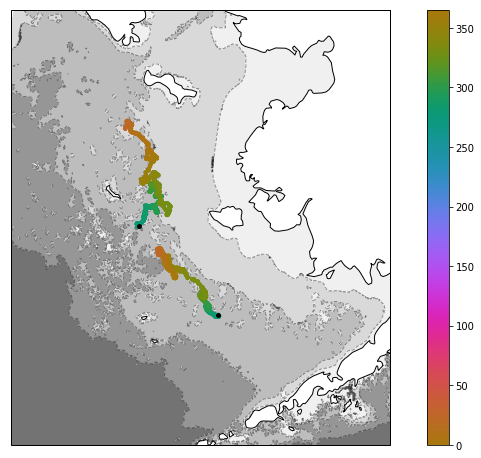

In [7]:
### BS Basin Wide
extent = [-176, -158, 54, 65]
erddap_etopo1()
(topoin, lats, lons) = etopo1_subset(file='data/etopo1_tmp.nc')

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()
fig,ax = make_map(projection=projection)

## Scatter plot of integrated temp
CS = plt.scatter([df_136863['lon']],[df_136863['lat']],
        15, c=[df_136863['doyfrac']], linewidth=0, edgecolors='none', marker='o', vmin=0, vmax=365,
        cmap=cmocean.cm.phase, transform=transformation, zorder=3
        )
CS = plt.scatter([df_136866['lon']],[df_136866['lat']],
        15, c=[df_136866['doyfrac']], linewidth=0, edgecolors='none', marker='o', vmin=0, vmax=365,
        cmap=cmocean.cm.phase, transform=transformation, zorder=3
        )
plt.colorbar(CS)

ax.scatter([df_136863['lon'][0]],[df_136863['lat'][0]],
        15, c='k', transform=transformation, zorder=3
        )
ax.scatter([df_136866['lon'][0]],[df_136866['lat'][0]],
        15, c='k', transform=transformation, zorder=3
        )

## bathymetry contours
CS = plt.contour(lons, lats, topoin, [-1000, -100, -50, -25,], 
                 colors='k', alpha=0.4, linestyle='--', linewidths=1, zorder=2,
                 transform=transformation)
CS = plt.contourf(lons, lats, topoin, [-1000, -100, -50, -25,], 
                 colors=('#737373','#969696','#bdbdbd','#d9d9d9','#f0f0f0'), extend='both', zorder=1,
                 transform=transformation)

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

In [9]:
df_136863

,argosid,lat,lon,s1,s2,s3,s4,s5,s6,s7,s8,doy,fracday,doyfrac
year_doy_hhmm,,,,,,,,,,,,,,
2017-10-02 01:09:00,136863,57.467,-166.561,01,D9,61,3B,47,6C,DC,2,275,0.047917,275.047917
2017-10-02 02:30:00,136863,57.453,-166.673,01,D9,44,1E,06,DA,6E,2,275,0.104167,275.104167
2017-10-02 02:37:00,136863,57.457,-166.667,01,DD,44,1E,11,A3,23,3,275,0.109028,275.109028
2017-10-02 02:58:00,136863,57.462,-166.701,01,D9,3D,17,61,00,FF,2,275,0.123611,275.123611
2017-10-02 03:28:00,136863,57.457,-166.710,0A,D9,34,17,13,61,BC,1,275,0.144444,275.144444
2017-10-02 04:05:00,136863,57.447,-166.693,0A,D8,FC,DE,03,B8,88,1,275,0.170139,275.170139
2017-10-02 04:06:00,136863,57.446,-166.694,0A,D8,FC,DE,F1,A0,ED,3,275,0.170833,275.170833
2017-10-02 04:17:00,136863,57.444,-166.704,0A,D8,FC,DE,6B,D7,00,2,275,0.178472,275.178472
2017-10-02 05:46:00,136863,57.434,-166.706,0A,D8,E8,CA,5E,87,C9,2,275,0.240278,275.240278
